# Neural Network Trainings

_Author: Aline Van Driessche_

This notebook contains all code needed to perform Neural Network trainings (1D and 2D) on individual latitude information available from ECCO. Read section headings for more details on setup, preprocessing, and model training.

In [1]:
import sys
import pandas as pd

import paths
import pickle

sys.path.append("..")
from models.utils import *
from models.plotting_utils import *
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from models import train_alt, CNN1D, CNN2D

import matplotlib.pyplot as plt

In [2]:
# A helper function to subset 30S, since now the surface vars exist for all longitudes - values taken from basin function!
def mask_30S(inputs):
    mask = np.logical_or(np.logical_or(np.logical_and(inputs.longitude >= -180, 
                                                      inputs.longitude <= -71),
                                       np.logical_and(inputs.longitude >= 31, 
                                                      inputs.longitude <= 115)),
                         np.logical_and(inputs.longitude >= 153, 
                                        inputs.longitude <= 180))
    masked = inputs.where(mask, drop = True)

    return masked

In [3]:
# A helper function to format the input files based on a given latitude
def format_lat_lon(value):
    """Format latitude or longitude with N/S or E/W suffix."""
    if value < 0:
        return f"{abs(value)}S"
    else:
        return f"{value}N"

## Experiment Variables

In [46]:
data_home = paths.LOCAL_DIR
lats = [26, -30, -55, -60]
lat = lats[2]

## Loading and processing relevant data

In [47]:
# Retrieve the input covariates (ecco surface variables)
inputs = xr.open_dataset(f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}.nc").isel(latitude=slice(1,2))
if lat == -30:
    inputs = mask_30S(inputs)  # when working at 30S, they have to be masked, otherwise not
if lat == -55:
    inputs = inputs.dropna('longitude', how = 'all')
inputs

<xarray.Dataset>
Dimensions:    (time: 312, latitude: 1, longitude: 706)
Coordinates:
  * latitude   (latitude) float32 -54.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    SSH        (time, latitude, longitude) float32 -0.3674 -0.3674 ... -0.2765
    ZWS        (time, latitude, longitude) float32 0.09067 0.09067 ... 0.1572
    OBP        (time, latitude, longitude) float32 56.01 56.01 ... 54.15 54.15
    SSS        (time, latitude, longitude) float32 34.17 34.17 ... 34.2 34.2
    SST        (time, latitude, longitude) float32 9.228 9.228 ... 8.168 8.168

In [48]:
# Retrieve the output streamfunctions to train on (in density space)
outputs_fp = f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}_moc_density.pickle"

with open(outputs_fp, 'rb') as f:
    outputs = pickle.load(f).astype(np.float64)
outputs = np.expand_dims(outputs, 1) # grabbing just 30S

outputs = xr.Dataset(
            data_vars = {'moc' : (["time", "latitude"], outputs)}, 
            coords = {'time' : inputs.time, 'latitude' : np.atleast_1d(lat),}
        )

outputs

<xarray.Dataset>
Dimensions:   (time: 312, latitude: 1)
Coordinates:
  * time      (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
  * latitude  (latitude) int32 -55
Data variables:
    moc       (time, latitude) float64 -11.22 -15.2 -18.69 ... -3.688 -10.46

In [49]:
def align_dates(inputs, outputs):

    # Align the dates according to the data available for in- and output
    date_range = (inputs.time.values[0], inputs.time.values[-1]) # grabbing start and end date for inputs
    date_range = tuple([str(d).split('T')[0] for d in date_range]) # extracting just the date, w/o time
    print('Date range to align to:', date_range)
    return align_inputs_outputs(inputs, outputs, date_range = date_range, ecco=False)

In [50]:
def preprocess_inputs(inputs, history=1, coords = ["time"]):

    pp_data_surface = apply_preprocessing(inputs,
                              mode="inputs",
                              remove_season=False,
                              remove_trend=False,
                              standardize=True,
                              lowpass=False)

    return reshape_inputs(pp_data_surface, history=history, keep_coords=coords, data_vars=["OBP", "ZWS"])

In [51]:
def preprocess_outputs(outputs, X):
    # MOC strength preprocessing
    strength = apply_preprocessing(outputs,
                               mode="outputs",
                               remove_season=False,
                               remove_trend=False,
                               standardize=False,
                               lowpass=False)
    strength_np = strength.moc.squeeze().values
    
    # Necessary step to do convolutions along the right axis with pytorch tensors!
    dims = list(range(X.ndim))  
    dims[1], dims[-1] = dims[-1], dims[1]
    X = np.transpose(X, dims)

    conv_dims = 1
    if len(X.shape) == (conv_dims + 1):
        X = np.expand_dims(X, axis=-1)

    y = strength_np[-X.shape[0]:]
    
    """
    print()
    print('Inputs shape:', X.shape)
    print('Extra inputs shape:', X_extra.shape)
    print('Outputs shape:', y.shape)
    """
    return y

In [52]:
def define_train_and_validation_sets(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, stratify=None, random_state=123456)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=False, stratify=None, random_state=123456)

    device = "cuda" if t.cuda.is_available() else "cpu"

    Xt_train = t.tensor(X_train, device=device).double()
    Yt_train = t.tensor(y_train, device=device).double()
    Xt_valid = t.tensor(X_valid, device=device).double()
    Yt_valid = t.tensor(y_valid, device=device).double()
    Xt_test = t.tensor(X_test, device=device).double()
    Yt_test = t.tensor(y_test, device=device).double()
    return Xt_train, Yt_train, Xt_valid, Yt_valid, Xt_test, Yt_test

## Running Neural Networks Trainings

In [53]:
def get_input(outputs, inputs, history=1, coords=["time", "longitude"]):

    inputs, outputs = align_dates(inputs, outputs)
    X = preprocess_inputs(inputs, history=history, coords=coords)
    y = preprocess_outputs(outputs, X)
    
    return X, y

In [76]:
# Hyperparameters to tune
dropout = 0.1
n_pure_layers = 1
n_mix_layers = 1
n_channels_mult = 4
kernel_size = (3,3)           #For 2D input change this to (3x3)
model_iterations = 1

In [77]:
import importlib
importlib.reload(train_alt)

<module 'models.train_alt' from 'C:\\Users\\aline\\OTP\\models\\train_alt.py'>

In [78]:
def train_CNN(Xt_train, Yt_train):

    model = CNN2D.CNN2D(
        n_pure_layers=n_pure_layers, 
        n_mix_layers=n_mix_layers, 
        n_features=Xt_train.shape[1], 
        n_channels=Xt_train.shape[1]*n_channels_mult,
        kernel_size=kernel_size,
        dropout=dropout, 
    )

    model, train_loss = train_alt.train_model( #, val_loss
        model=model, 
        X_train = Xt_train, 
        y_train = Yt_train, 
        #X_val = Xt_valid,
        #y_val = Yt_valid, 
        #early_stopping=True,
    )
    return model

In [79]:
def predict_CNN(model, Xt_train, Yt_train, Xt_valid, Yt_valid, Xt_test, y_test):
    model =  model.double()

    # Extracting all predictions in time order
    train_set_pred = train_alt.predict(model, Xt_train, Yt_train)
    valid_set_pred = train_alt.predict(model, Xt_valid, Yt_valid)
    test_set_pred = train_alt.predict(model, Xt_test, y_test)
    
    predictions = {
        "train_set_pred": train_set_pred, 
        "valid_set_pred": valid_set_pred, 
        "test_set_pred": test_set_pred, 
        "all_preds": np.concatenate([train_set_pred, valid_set_pred, test_set_pred])
    }
    
    print('test set', np.array(test_set_pred).shape)
    print(y_test.shape)
    
    metrics = {
        "rmse": round(root_mean_squared_error(test_set_pred, y_test), 3),
        "mae": round(mean_absolute_error(test_set_pred, y_test), 3),
        "mape": round(mean_absolute_percentage_error(test_set_pred, y_test), 3)*100,        
        "cmape": round(custom_MAPE(np.array(test_set_pred).squeeze(), y_test.detach().cpu().numpy(), threshold=0.5), 3)*100,
        "test_corr": round(np.corrcoef(np.array(test_set_pred).squeeze(), y_test)[0, 1], 3),
        }
    
    return predictions, metrics

In [80]:
# To loop over several models and compare the performances
models = []
history = 6 #np.arange(6)
for i in range(10):
    X, y= get_input(outputs, inputs, history=history, coords=["time", "longitude"])
    Xt_train, Yt_train, Xt_valid, Yt_valid, Xt_test, Yt_test = define_train_and_validation_sets(X, y)
    models.append(train_CNN(Xt_train, Yt_train))

predictions_models = []
metrics_models = []

for i in range(len(models)):
    X, y= get_input(outputs, inputs, history=history)
    Xt_train, Yt_train, Xt_valid, Yt_valid, Xt_test, Yt_test = define_train_and_validation_sets(X, y)
    predictions, metrics = predict_CNN(models[i], Xt_train, Yt_train, Xt_valid, Yt_valid, Xt_test, Yt_test )
    predictions_models.append(predictions)
    metrics_models.append(metrics)

metrics_df = pd.DataFrame(metrics_models)
summary_metrics_df = pd.DataFrame({
                "mean": metrics_df.mean().round(3), 
                "std": metrics_df.std().round(3)}
            )
display(summary_metrics_df)

predictions_df = pd.DataFrame(predictions_models)

Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'longitude', 'feature']
variables: ['OBP', 'ZWS']
shape: (307, 6, 706, 2)
device: cpu
1705 parameters.


100%|██████████| 5000/5000 [01:45<00:00, 47.34it/s]


Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'longitude', 'feature']
variables: ['OBP', 'ZWS']
shape: (307, 6, 706, 2)
device: cpu
1705 parameters.


100%|██████████| 5000/5000 [02:02<00:00, 40.90it/s]


Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'longitude', 'feature']
variables: ['OBP', 'ZWS']
shape: (307, 6, 706, 2)
device: cpu
1705 parameters.


100%|██████████| 5000/5000 [03:49<00:00, 21.79it/s]


Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'longitude', 'feature']
variables: ['OBP', 'ZWS']
shape: (307, 6, 706, 2)
device: cpu
1705 parameters.


100%|██████████| 5000/5000 [07:24<00:00, 11.24it/s]


Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'longitude', 'feature']
variables: ['OBP', 'ZWS']
shape: (307, 6, 706, 2)
device: cpu
1705 parameters.


100%|██████████| 5000/5000 [04:32<00:00, 18.38it/s]


Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'longitude', 'feature']
variables: ['OBP', 'ZWS']
shape: (307, 6, 706, 2)
device: cpu
1705 parameters.


100%|██████████| 5000/5000 [03:32<00:00, 23.48it/s]


Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'longitude', 'feature']
variables: ['OBP', 'ZWS']
shape: (307, 6, 706, 2)
device: cpu
1705 parameters.


100%|██████████| 5000/5000 [07:13<00:00, 11.53it/s]


Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'longitude', 'feature']
variables: ['OBP', 'ZWS']
shape: (307, 6, 706, 2)
device: cpu
1705 parameters.


100%|██████████| 5000/5000 [06:19<00:00, 13.18it/s]


Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'longitude', 'feature']
variables: ['OBP', 'ZWS']
shape: (307, 6, 706, 2)
device: cpu
1705 parameters.


100%|██████████| 5000/5000 [07:26<00:00, 11.20it/s]


Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'longitude', 'feature']
variables: ['OBP', 'ZWS']
shape: (307, 6, 706, 2)
device: cpu
1705 parameters.


100%|██████████| 5000/5000 [07:46<00:00, 10.72it/s]


Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'longitude', 'feature']
variables: ['OBP', 'ZWS']
shape: (307, 6, 706, 2)
test set (62,)
torch.Size([62])
Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'longitude', 'feature']
variables: ['OBP', 'ZWS']
shape: (307, 6, 706, 2)
test set (62,)
torch.Size([62])
Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'longitude', 'feature']
variables: ['OBP', 'ZWS']
shape: (307, 6, 706, 2)
test set (62,)
torch.Size([62])
Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'longitude', 'feature']
variables: ['OBP', 'ZWS']
shape: (307, 6, 706, 2)
test set (62,)
torch.Size([62])
Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'longitude', 'feature']
variables: ['OBP', 'ZWS']
shape: (307, 6, 706, 2)
test set (62,)
torch.Size([62])
Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'histor

,mean,std
rmse,3.817,0.158
mae,3.150,0.162
mape,49.550,13.603
cmape,44.360,10.050
test_corr,0.740,0.027


In [ ]:
metrics_df.to_csv(f"{paths.LOCAL_DIR}/{lat}_history.csv")

In [783]:
plot_30 = pd.read_csv(f"{paths.LOCAL_DIR}/-30_history.csv")
plot_55 = pd.read_csv(f"{paths.LOCAL_DIR}/-55_history.csv")
plot_60 = pd.read_csv(f"{paths.LOCAL_DIR}/-60_history.csv")

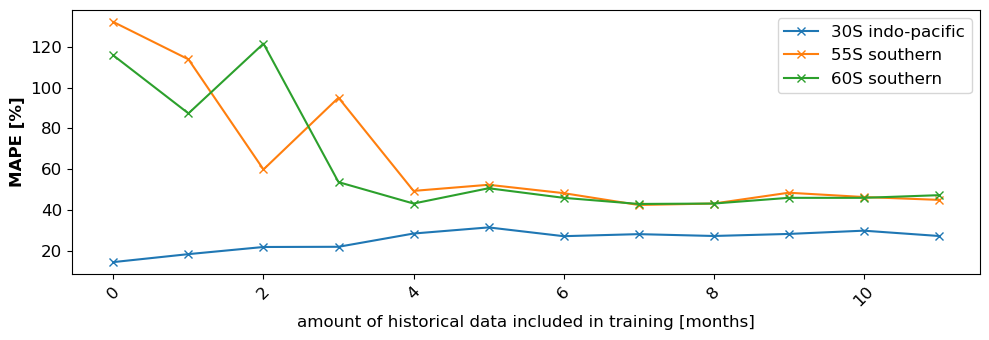

In [803]:
# Plotting
plt.figure(figsize=(10, 3.5))  # Optional: specifies the figure size
plt.plot(plot_30.index, plot_30['mape'], marker='x', linestyle='-', linewidth=1.5, label='30S indo-pacific')  
plt.plot(plot_55.index, plot_55['mape'], marker='x', linestyle='-', linewidth=1.5, label='55S southern') 
plt.plot(plot_60.index, plot_60['mape'], marker='x', linestyle='-', linewidth=1.5, label='60S southern') 
plt.xlabel('amount of historical data included in training [months]', fontsize=12)
plt.ylabel('MAPE [%]', fontsize=12, weight="bold")
plt.legend(fontsize=12) 
plt.tick_params(labelsize=12)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area.
plt.savefig(f"C:/Users/aline/OTP/plots/history1DCNN.png", dpi=400)
plt.show()

## Output visualisation

307


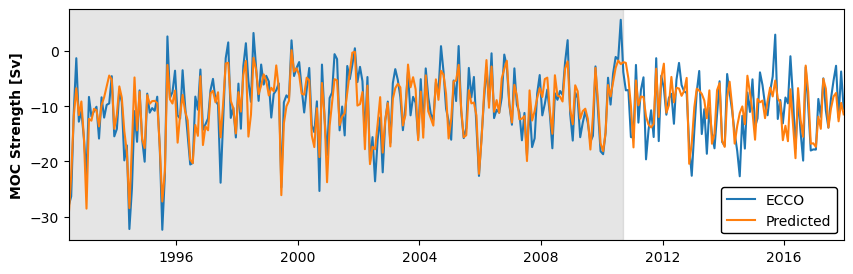

In [93]:
#predictions_df = pd.DataFrame(predictions)
#mean_y = {col: np.mean(np.stack(predictions_df[col].values), axis=0) for col in predictions_df}

predictions = predictions_models[9]

print(len(predictions['all_preds']))

time = outputs.time.values[-X.shape[0]:]
fig, ax = timeseries_comparison(predictions['all_preds'], 
                                y,
                                time, 
                                len(Xt_train))
plt.show()

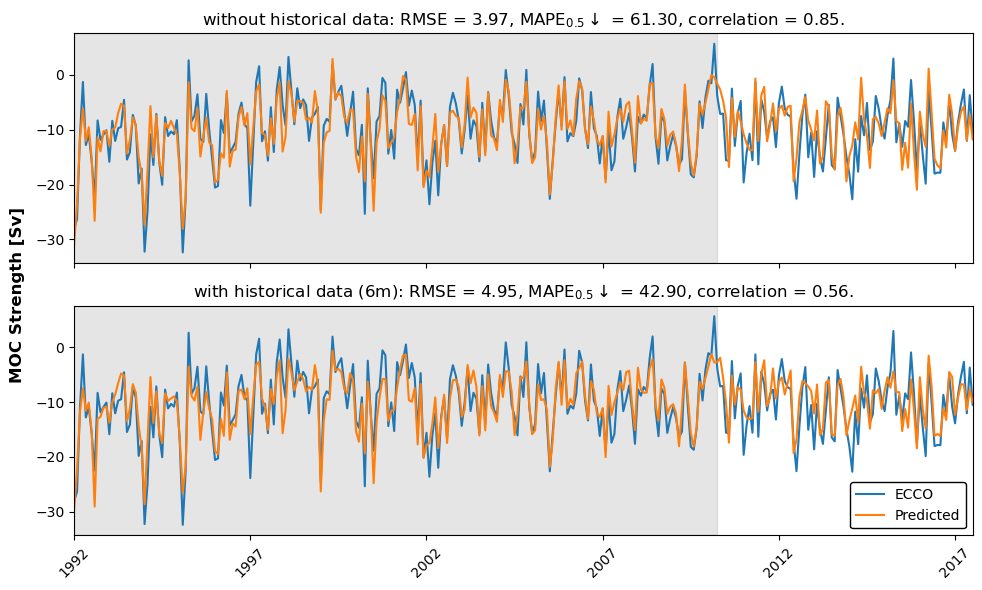

In [108]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, squeeze=True, figsize=(10, 6))

all_moc = [y, y]
all_pred = [predictions_models[0]['all_preds'], predictions_models[1]['all_preds']]
sections = ['without historical data: RMSE = 3.97, MAPE$_{0.5}\\downarrow$ = 61.30, correlation = 0.85.', 'with historical data (6m): RMSE = 4.95, MAPE$_{0.5}\\downarrow$ = 42.90, correlation = 0.56.']

for index, ax in enumerate(axs):
    ax.plot(all_moc[index], label="ECCO")
    ax.plot(all_pred[index], label="Predicted")
    # all this stuff is emilio's plotting code
    y_lower, y_upper = ax.get_ylim()
    x_pos = np.arange(len(Xt_train))
    ax.fill_between(x = x_pos, 
                    y1 = np.repeat(y_lower, len(x_pos)), 
                    y2 = np.repeat(y_upper, len(x_pos)),
                    alpha = 0.2, 
                    color = 'gray')
    ax.margins(x = 0, y = 0)
    ax.set_title(sections[index])
# and here also, just emilio's code
ax.set_xticks(np.arange(0, 324, 60), np.arange(1992, 2019, 5), rotation=45)
ax.legend(loc = 'lower right', edgecolor = 'black', framealpha = 1)
fig.supylabel("MOC Strength [Sv]", weight="bold")
plt.tight_layout()
# dpi makes the plot more hd
plt.savefig(f"C:/Users/aline/OTP/plots/55S_historicaldata.png", dpi=400)
plt.show()

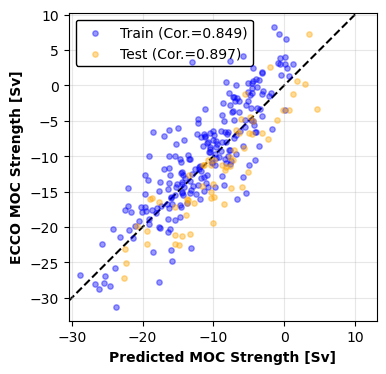

In [871]:
# Alternate view: looking at a scatterplot of predicted vs. actual
y_pred_train = np.array(mean_y['train_set_pred']).squeeze()
y_pred_test = np.array(mean_y['test_set_pred']).squeeze()

fig, ax = pred_vs_actual(y_pred_train, y_pred_test, y_train, y_test)
plt.show()